## 1. Introdução
A evasão de clientes é um dos principais desafios enfrentados por empresas que oferecem serviços recorrentes. Com um mercado cada vez mais competitivo, compreender os fatores é fundamental para reduzir perdas e aumentar a fidelização dos clientes.
&nbsp;

O objetivo desse projeto é analisar os fatores que influenciam o abandono dos clientes e desenvolver um modelo de Machine Learning para prever quais clientes têm maior probabilidade de cancelar no futuro.

Os dados utilizados foram disponibilizados no site: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

## 2. Principais perguntas
Perguntas que tentaremos responder com essa análise:
- Quais as principais características relacionadas ao churn?
- É possível prever o churn com Machine Learning?
- Quais as principais tomadas de decisão para reduzir os cancelamentos?

## 3. Carregando bibliotecas e o dataset
Primeiramente, iremos carregar as bibliotecas utilizadas no projeto e carregar os dados utilizados.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

df = pd.read_csv("../Data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 4. Limpeza e pré-processamento dos dados
Nessa etapa, iremos garantir que o conjunto de dados esteja pronto para análise e modelagem. Primeiro, verificaremos a existência de valores ausentes ou inconsistentes, que podem impactar a qualidade dos resultados. Em seguida, ajustaremos o tipo das variáveis (convertendo colunas numéricas importadas como texto) e transformaremos variáveis categóricas em formato binário, para poderem ser utilizadas adequadamente pelos algoritmos de Machine Learning.


In [2]:
# Verificação de dados ausentes
df.info()

print("Valores nulos: \n",df.isnull().sum())

# Corrigindo colunas numéricas salvas como string
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Converter colunas para binario
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 5. Análise exploratória (EDA)
Nessa etapa, vamos analisar as variáveis categóricas e numéricas para entender os fatores que influenciam o cancelamento dos clientes.

#### 1.1 Distribuição de churns
Primeiro, iremos visualizar a distribuição de clientes que cancelaram (Churn = Sim) e dos que permaneceram (Churn = Não).

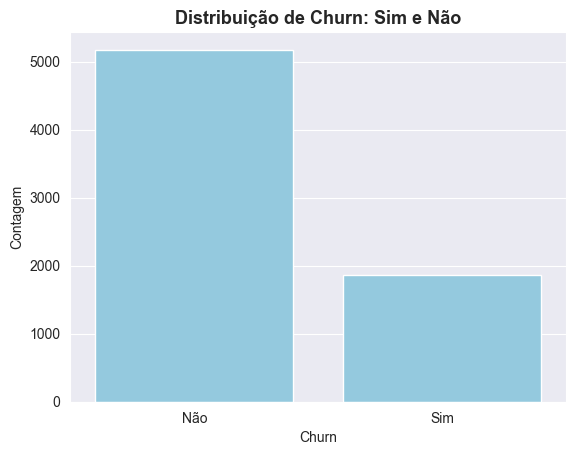

In [3]:
sns.countplot(x=df["Churn"].map({0: "Não", 1: "Sim"}), color="skyblue")
plt.title("Distribuição de Churn: Sim e Não", fontsize=13, weight="bold")
plt.xlabel("Churn")
plt.ylabel("Contagem")
plt.show()

#### 1.2 Relação com variáveis categóricas
Aqui, é verificado a taxa média de cancelamento (em %) para cada categoria.

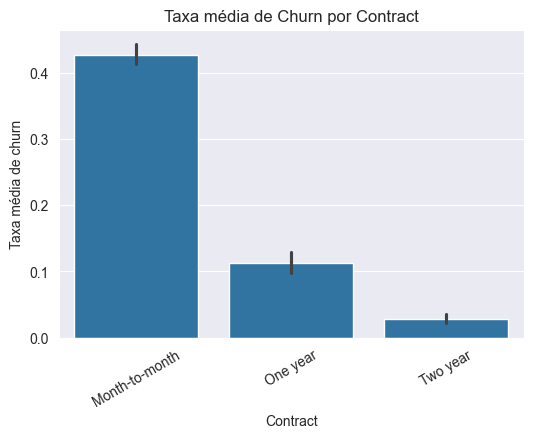

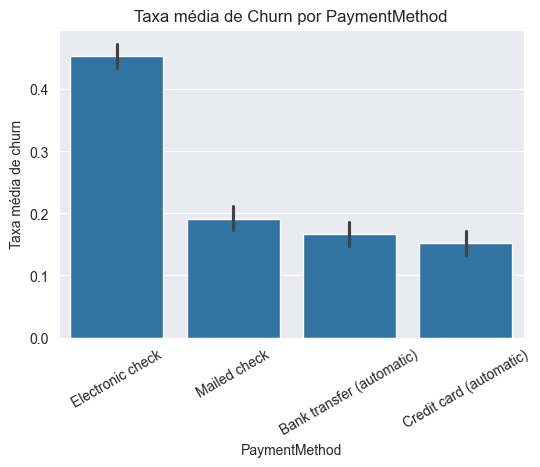

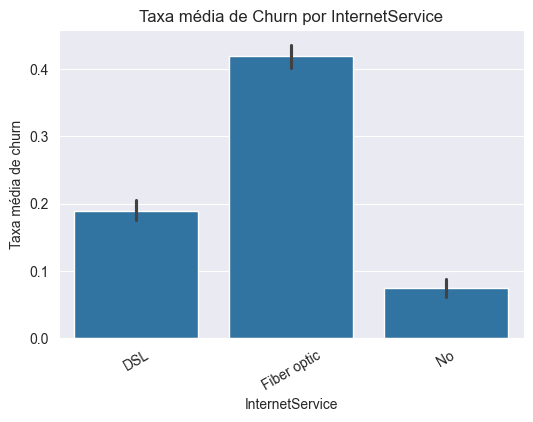

In [4]:
categorical_cols = ["Contract", "PaymentMethod", "InternetService"]
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.barplot(x=col, y="Churn", data=df, estimator=np.mean)
    plt.title(f"Taxa média de Churn por {col}")
    plt.xticks(rotation=30)
    plt.ylabel("Taxa média de churn")
    plt.show()

#### 1.3 Correlação entre variáveis numéricas
Agora, iremos analisar as relações entre as variáveis numéricas para identificar padrões que possam estar associados aos cancelam.

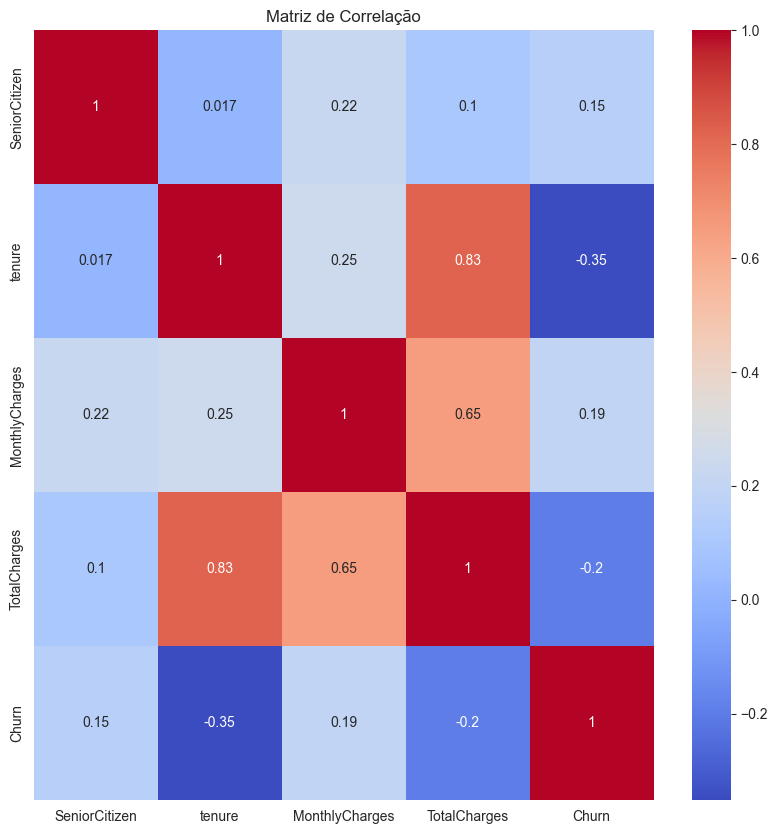

In [6]:
plt.figure(figsize=(10,10))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

# 6. Modelo de Machine Learning
Foi criado um modelo de Machine Learning para prever se um cliente irá cancelar o serviço com base em informações contratuais, de uso e pagamentos. Logo abaixo, cada etapa do código é explicada separadamente.

### 1.1 Pré-processamento dos dados


In [7]:
if "CustomerID" in df.columns:
    df.drop("CustomerID", axis = 1, inplace = True)

df = pd.get_dummies(df, drop_first=True)

- Coluna "CustomerID" removida, pois não contribui para a predição.
- Usamos pd.get_dummies() para transformar variáveis categóricas em binárias (one-hot-encoding).

### 1.2 Separação entre variáveis explicativas e alvo

In [ ]:
X = df.drop(columns=[col for col in df.columns if "Churn" in col])
y = df["Churn_Yes"] if "Churn_Yes" in df.columns else df["Churn"]


- X possui as variáveis para preditoras.
- Y possui a variável que queremos prever ("Churn").

Em seguida, são divididos em treino e teste:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 1.3 Padronização e balanceamento

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

- Padroniza as features para que todas fiquem na mesma escala.

In [ ]:
sm = SMOTE(random_state=42)
X_train_res,y_train_res  = sm.fit_resample(X_train_scaled, y_train)

- É utilizado _SMOTE_ para resolver os problemas de desbalanceamento e melhorar a capacidade preditiva.

### 1.4 Treinamento dos modelos

In [ ]:
# RandomForest
rf = RandomForestClassifier(random_state=42,n_estimators= 100, min_samples_split= 5, min_samples_leaf= 1, max_features= 'log2', max_depth= None, class_weight= 'balanced')
rf_params = {
     "n_estimators": [100, 200, 300, 500],
     "max_depth": [5, 10, 20, None],
     "min_samples_split": [2, 5, 10],
     "min_samples_leaf": [1, 2, 4],
     "max_features": ["sqrt", "log2"]
    }
rf_search = RandomizedSearchCV(rf, rf_params, cv=5, n_iter=20,scoring='f1', n_jobs=-1, random_state=42)
rf_search.fit(X_train_res, y_train_res)
best_rf = rf_search.best_estimator_

- Utilizamos um conjunto de árvores de decisão (Random Forest).
- O RandomizedSearchCV() testa combinações de parâmetros para encontrar a configuração com melhor performance.

In [ ]:
 # XGBoost
xgb = XGBClassifier(
    n_estimators= 300,
     learning_rate= 0.05,
     max_depth= 6,
     subsample= 0.8,
     colsample_bytree= 0.8,
     random_state= 42,
     use_label_encoder = False,
     eval_metric= "logloss"
    )
xgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
     'max_depth': [3, 5, 7, 10],
     'subsample': [0.7, 0.8, 0.9],
     'colsample_bytree': [0.7, 0.8, 0.9],
     'gamma': [0, 0.1, 0.3]
    }
xgb_search = RandomizedSearchCV(xgb, xgb_params, cv = 5, n_iter= 20, scoring= 'f1', n_jobs=-1, random_state= 42)
xgb_search.fit(X_train_res, y_train_res)
best_xgb = xgb_search.best_estimator_

- Também foi utilizado um modelo de boosting (XGBoost) para detectar padrões complexos.

### 1.5 Stacking dos modelos

In [ ]:
# Stacking
base_models = [
    ("rf", best_rf),
    ("xgb", best_xgb)
]
meta_model = LogisticRegression(max_iter=1000, random_state=42)
stacking= StackingClassifier(
    estimators = base_models,
    final_estimator= meta_model,
    cv= 5,
    stack_method= "predict_proba",
    n_jobs= -1
    )
stacking.fit(X_train_res,y_train_res)

- O stacking combina as previsões dos modelos.
- Esse modelo reduz o viés e variância, aumentando a precisão dos resultados.

### 1.6 Avaliação dos resultados

In [ ]:
 # Avaliacao
pred = stacking.predict(X_test_scaled)
proba = stacking.predict_proba(X_test_scaled)[:, 1]

print("Parâmetros randomforest:",rf_search.best_params_)
print("Relatorio de classificação",classification_report(y_test, pred))
print("ROC_AUG:",round(roc_auc_score(y_test, proba),3))
print("Matriz de Confusão", confusion_matrix(y_test, pred))

Metricas utilizadas para avaliar o modelo:
- ROC-AUC(capacidade do modelo em separar classe)
- Matriz de confusao(acertos e erros por classe)
- Relatório de classificação (precision, recall e F1-score)

# 7. Insights Obtidos
Com base na análise dos dados realizada, identificamos padrões relevantes que ajudam a compreender o comportamento de clientes que tendem a cancelar o serviço.

### **Impacto do Tipo de Contrato**

- Clientes que possuem contrato mensal representam 88,55% dos cancelamentos.
- Contratos anuais e bienais somam menos de 15% dos cancelamentos totais. Isso mostra que contratos de longo prazo reduzem drasticamente a quantidade de cancelamentos.

<center> <img src = "Cancelamentos.jpg" alt = "jpg_python" width = "900"> </center>



### **Importância do Suporte Técnico**
- O maior número de cancelamentos ocorre entre clientes sem acesso ao suporte técnico.
- Clientes sem internet são o menor grupo. Isso indica que não dependem tanto do suporte técnico ou são um nicho específico.
- Quando há acesso ao suporte, a quantidade de cancelamentos é reduzida significativamente.
<center> <img src = "TechSupport.jpg" alt = "jpg_python" width = "900"> </center>

### **Tempo de Permanência**
- O maior número de cancelamentos ocorre entre 0 e 6 meses.
- Clientes que permanecem mais de 2 anos demonstram maior lealdade à empresa.
- Há um aumento expressivo de clientes ativos entre 24 e 36 meses. Isso indica que planos bienais são importantes para retenção de clientes.

<center> <img src = "Tenure.jpg" alt = "jpg_python" width = "900"> </center>

# 8. Recomendações
Com base nos insights obtidos, recomendamos as seguintes ações:
1. Melhorar onboarding e suporte inicial
- Criar um programa de acompanhamento nos primeiros meses, com foco em clientes novos.
- Oferecer suporte proativo nas primeiras semanas.
2. Incentivar planos de maior valor
- Criar planos personalizados para novos usuários com benefícios e descontos exclusivos.
- Identificar clientes com alto risco de evasão e abordá-los com ofertas direcionadas.
3. Aprimorar o suporte técnico.
- Reduzir o tempo para o atendimento e aumentar a resolução no primeiro contato.
- Melhorias no atendimento com foco em retenção e empatia com o cliente.
4. Monitorar indicadores de risco
- Utilizar o modelo de machine learning para classificar novos clientes por nível de risco, tomando ações preventivas.

# 9. Contato
Samuel Lellis
&nbsp;

 https://www.linkedin.com/in/samuel-lellis-293258346
&nbsp;

 https://github.com/SamuelLellis1

&nbsp;
samuellellis1337@gmail.com